# Model

In this optimisation problem, we minimise the distance between the estimated location and the distances estimated by each anchor, subject to some other considerations.

For $A$ anchors, with coordinates $(a_{1,x}, a_{1,y}), (a_{2,x}, a_{2,y}), (a_{3,x}, a_{3,y})$ and $|A| \ge 1$

Given $(x_i, y_i, r_i)$ for $i \in {1...P}$ for $P$ data points

To summarise the sections of the created optimization problem, we can break them down into several, easier to understand constraints and objectives

### 1. Objective: 
Minimise the distance between the anchor’s estimation and our predicted location.

###  2. Path Deviance Rule: 
For this problem, we assume the path is at y = 300. The estimated
location should not be further than ε from the path.

### 3. Path Adherence Rule: 
In the diagram in the instructions, there are multiple, perpendicular
paths, but the question only has one path. I will make this solution generalisable to more than 1
path. The path adherence rule makes it such that the distance from any path d applies to only
one path. It would be strange to calculate distance from 0 or more than 1 path. I therefore assume that the paths are strictly horizontal or vertical, and use a binary decision variable to ensure only 1 path is eventually considered.

### 4. Corridor Rule: 
In a similar scenario to the above rule, I will make this solution generalisable to
many corridors. I use a similar binary variable method to ensure that the estimation location does
not clip into a wall. This rule is slightly different from the above rule, since an estimated location
can be within 2 corridors, like when the location is at an intersection.

### 5. Anchor Distance Rule: 
This method minimises the sum of differences between the anchor’s
estimations and the Euclidean distances to anchors of our estimation. In this step, I arrange the
rules such that the calculated error is the absolute, strictly nonnegative error.
Optimization Problem

## Objective:

Let $L_a$ be the Euclidean distance from (x,y) to an anchor $a \in A$

minimize $\sum^{|A|}_{i=1} L_i$ subject to

## Path Deviance Rule: 

Let $d$ be the distance between the estimated location and the path, it should be less than $\epsilon$

$\quad d \le \epsilon$

$d$ should be greater or equal to the shortest distance to a path

## Path Adherence Rule: 

For $I$ vertical paths $p_x$ and $J$ horizontal paths $p_y$, labelled from $p_{x,1},... p_{x,|I|}$ and $p_{y,1},...p_{y,|J|}$ respectively

The binary variables for horizontal paths are $b_h$ and the vertical paths are $b_v$

Let B be the combined set of binary variables, where $B=\{b_{v,1},... b_{v,|I|}, b_{h,1},...b_{h,|J|}\}$

$\quad d \ge (x-p_{x,i})b_{v,i} \quad \forall i \in \{1,...,|I|\}$

$\quad d \ge (p_{x,i}-x)b_{v,i} \quad \forall i \in \{1,...,|I|\}$

$\quad d \ge (y-p_{y,j})b_{h,j} \quad \forall j \in \{1,...,|J|\}$

$\quad d \ge (p_{y,j}-y)b_{h,j} \quad \forall j \in \{1,...,|J|\}$

$\quad \sum_{i=1}^{|I|}b_i + \sum_{j=1}^{|J|}b_j = 1$

$\quad b_i\in\{0,1\}$

$\quad b_j\in\{0,1\}$

$\quad d, \epsilon, x, y \ge 0$

## Corridor Rule: 

$x$ and $y$ should be in valid corridors, defined for $M$ vertical corridors $c_x$ by 2 $x$ coordinates $c_{x,m,s}$ and $c_{x,m,e} \quad \forall m \in \{1,...,|M|\}$ where $c_{x,m,s} < c_{x,m,e}$

and for $N$ horizontal corridors $c_y$ by 2 $y$ coordinates $c_{y,n,s}$ and $c_{y,n,e} \forall n \in N$
where $c_{y,n,s} < c_{y,n,e}$ 

($s$ and $e$ stand for start and end respectively)

The binary variables for horizontal paths are $b_y$ and the vertical paths are $b_x$ used to ensure that the location exists within at least one corridor

Let B be the combined set of binary variables, where $B=\{b_{x,1},... b_{x,|M|}, b_{y,1},...b_{y,|N|}\}$

The important corridor is between y=200 and y=400 as shown in the animation on the assignment

$\quad x*b_m \ge c_{x,m,s}*b_{x,m} \quad  \forall m \in \{1,...,|M|\}$

$\quad x*b_m \le c_{x,m,e}*b_{x,m} \quad  \forall m \in \{1,...,|M|\}$

$\quad y*b_n \ge c_{y,n,s}*b_{y,n} \quad  \forall n \in \{1,...,|N|\}$

$\quad y*b_n \le c_{y,n,e}*b_{y,n} \quad  \forall n \in \{1,...,|N|\}$

$\quad 1 \ge \sum^{|M|}_{m=1}b_m \ge 0$

$\quad 1 \ge \sum^{|N|}_{n=1}b_n \ge 0$

$\quad 2 \ge \sum^{|M|}_{m=1}b_m + \sum^{|N|}_{n=1}b_n \ge 1$

## Anchor Distance Rule:

The Euclidean distance from $(x, y)$ to anchor $a \in A$ is $L_a$

$\quad L_a \ge (x-a_{x})^2 + (y-a_{y})^2 - r_p^2 \quad \forall a \in \{1,...,|A|\}, \quad \forall p \in P$

$\quad L_a \ge -1 * (x-a_{x})^2 + (y-a_{y})^2 - r_p^2 \quad \forall a \in \{1,...,|A|\}, \quad \forall p \in P$

$\quad L_a \ge 0 \quad \forall a \in \{1,...,|A|\}$

# Implementation

In [9]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
hor_paths = [300]
vert_paths = [1500, 2000]

hor_corridors = [[200, 400]]
vert_corridors = [[1400, 1600], [1900, 2100]]

anchors = [[100, 200], [400, 400], [700, 200]]

In [11]:
def find_pos(input_row, epsilon):
    model = pyo.ConcreteModel()

    model.d = pyo.Var(domain=pyo.NonNegativeReals)
    model.error = pyo.Var(domain=pyo.NonNegativeReals)

    model.x = pyo.Var(domain=pyo.NonNegativeReals)
    model.y = pyo.Var(domain=pyo.NonNegativeReals)

    model.epsilon_constraint = pyo.Constraint(expr=model.d <= epsilon)

    # First Part

    model.I = pyo.Var(list(range(1, len(vert_paths) + 1)), domain=pyo.Binary)
    model.vert_path_cons = pyo.ConstraintList()
    for i, vp in enumerate(vert_paths):
        model.vert_path_cons.add(model.d >= (model.x - vp) * model.I[i+1])
        model.vert_path_cons.add(model.d >= (vp - model.x) * model.I[i+1])

    model.J = pyo.Var(range(1, len(hor_paths) + 1), domain=pyo.Binary)
    model.hor_path_cons = pyo.ConstraintList()
    for j, hp in enumerate(hor_paths):
        model.hor_path_cons.add(model.d >= (model.y - hp) * model.J[j+1])
        model.hor_path_cons.add(model.d >= (hp - model.y) * model.J[j+1])

    def path_constraint(model):
        return sum(model.I[i] for i in model.I) + sum(model.J[j] for j in model.J) == 1

    model.path_constraint = pyo.Constraint(rule=path_constraint)

    # Second Part

    model.N = pyo.Var(range(1, len(hor_corridors) + 1), domain=pyo.Binary)
    model.hor_corr_cons = pyo.ConstraintList()

    for n, hc in enumerate(hor_corridors):
        model.hor_corr_cons.add(model.y * model.N[n+1] >= hc[0] * model.N[n+1])
        model.hor_corr_cons.add(model.y * model.N[n+1] <= hc[1] * model.N[n+1])

    model.M = pyo.Var(range(1, len(vert_corridors) + 1), domain=pyo.Binary)
    model.vert_corr_cons = pyo.ConstraintList()

    for m, vc in enumerate(hor_corridors):
        model.vert_corr_cons.add(model.x * model.M[m+1]>= vc[0] * model.M[m+1])
        model.vert_corr_cons.add(model.x * model.M[m+1]<= vc[1] * model.M[m+1])

    model.hor_corr_cons.add(sum(model.N[n] for n in model.N) >= 0)
    model.hor_corr_cons.add(sum(model.N[n] for n in model.N) <= 1)

    model.vert_corr_cons.add(sum(model.M[m] for m in model.M) >= 0)
    model.vert_corr_cons.add(sum(model.M[m] for m in model.M) <= 1)

    model.corridor_constraints = pyo.ConstraintList()
    model.corridor_constraints.add(sum(model.M[m] for m in model.M) + sum(model.N[n] for n in model.N) >= 1)
    model.corridor_constraints.add(sum(model.M[m] for m in model.M) + sum(model.N[n] for n in model.N) <= 2)

    model.distance_constraints = pyo.ConstraintList()

    model.L = pyo.Var(range(1, len(anchors) + 1), domain=pyo.NonNegativeReals)
    model.err_cons = pyo.ConstraintList()

    for a in range(1, len(anchors) + 1):
        model.err_cons.add(model.L[a] >= (model.x - anchors[a-1][0])**2 + (model.y - anchors[a-1][1])**2 - input_row[a-1]**2)
        model.err_cons.add(model.L[a] >= -1 * (model.x - anchors[a-1][0])**2 + (model.y - anchors[a-1][1])**2 - input_row[a-1]**2)

    model.error_constraint = pyo.Constraint(expr= sum(model.L[a] for a in range(1, len(anchors) + 1)) <= model.error)

    model.obj = pyo.Objective(expr=model.error, sense=pyo.minimize)

    solver = pyo.SolverFactory('ipopt')
    solver.solve(model)

    return model.x.value, model.y.value

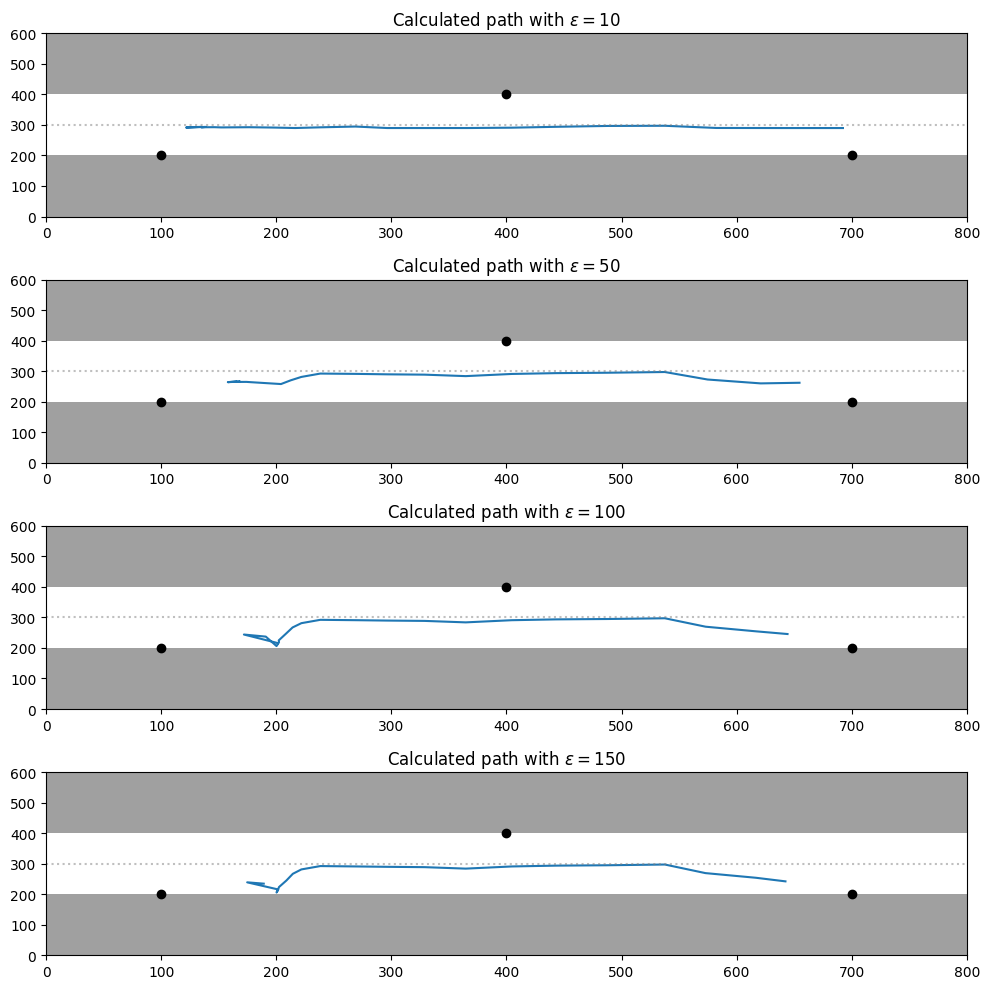

In [12]:
distances = pd.read_csv("distances.csv")

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

for e, epsi in enumerate([10, 50, 100, 150]):
    result_list = []

    for i, row in distances.iterrows():
        inp = [row['anchor_1'], row['anchor_2'], row['anchor_3']]
        result_list.append(find_pos(inp, epsi))

    df = pd.DataFrame(result_list, columns=['x', 'y'])

    axs[e].plot(df['x'], df['y'])

    axs[e].set_xlim(0, 800)
    axs[e].set_ylim(0, 600)

    axs[e].axhspan(0, 200, color='grey', alpha=0.75, lw=0)
    axs[e].axhspan(400, 600, color='grey', alpha=0.75, lw=0)

    axs[e].axhline(y=300, color='grey', linestyle='dotted', alpha=0.5)

    x_coords = [point[0] for point in anchors]
    y_coords = [point[1] for point in anchors]

    # Plot the points
    axs[e].scatter(x_coords, y_coords, color='black')

    axs[e].set_title('Calculated path with $\epsilon=$' + str(epsi))

plt.tight_layout()